<a href="https://colab.research.google.com/github/REYES-AFMR/BEELEC1-IndivProj/blob/main/BEELEC1_IndivProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTING: Import relevant libraries

# will emable you to manipulate files purely online (interacts with operating system)
import os
# numerical operations (matrices)
import numpy as np

# computer vision
import cv2
# image processing
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Rescaling, Resizing, Reshape
from keras import ops
from keras import utils
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from keras.utils import to_categorical
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots and charts
import matplotlib.pyplot as plt

from types import NoneType

In [ ]:
# LOADING IMAGES:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/[1] 24-25/SEM 8//BEELEC1/IndivPaper/Bone_Fracture_Binary_Classification'

# dataset already divided into train, test, and validate
# feature outputs will remain separated

# in train folder:
trainPath = os.path.join(dataset_path, "train")
# test folder:
testPath = os.path.join(dataset_path, "test")
# validate folder:
valPath = os.path.join(dataset_path, "val")

# category per folder: not fracture (0) and fracture (1)
trainNotPath = os.path.join(trainPath, "not fractured")
trainFracPath = os.path.join(trainPath, "fractured")

testNotPath = os.path.join(testPath, "not fractured")
testFracPath = os.path.join(testPath, "fractured")

valNotPath = os.path.join(valPath, "not fractured")
valFracPath = os.path.join(valPath, "fractured")

# TRAIN FOLDER:
trainIMG = []
trainLABEL = []

# not fractured:
for i in os.listdir(trainNotPath):
  tempImg = cv2.imread(os.path.join(trainNotPath, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256))
    trainIMG.append(resizedImg)
    trainLABEL.append(0)
  else:
    continue


for i in os.listdir(trainFracPath):
  tempImg = cv2.imread(os.path.join(trainFracPath, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256))
    trainIMG.append(resizedImg)
    trainLABEL.append(1)
  else:
    continue

# TEST FOLDER:
testIMG = []
testLABEL = []

# not fractured:
for i in os.listdir(testNotPath):
  tempImg = cv2.imread(os.path.join(testNotPath, i))
  if type(tempImg) is not NoneType:
      resizedImg = cv2.resize(tempImg, (256, 256))
      testIMG.append(resizedImg)
      testLABEL.append(0)
  else:
    continue


# fractured:
for i in os.listdir(testFracPath):
  tempImg = cv2.imread(os.path.join(testFracPath, i))
  if type(tempImg) is not NoneType:
      resizedImg = cv2.resize(tempImg, (256, 256))
      testIMG.append(resizedImg)
      testLABEL.append(1)
  else:
    continue


# VALIDATE FOLDER:
valIMG = []
valLABEL = []

# not fractured:
for i in os.listdir(valNotPath):
  tempImg = cv2.imread(os.path.join(valNotPath, i))
  if type(tempImg) is not NoneType:
      resizedImg = cv2.resize(tempImg, (256, 256))
      valIMG.append(resizedImg)
      valLABEL.append(0)
  else:
    continue


# fractured:
for i in os.listdir(valFracPath):
  tempImg = cv2.imread(os.path.join(valFracPath, i))
  if type(tempImg) is not NoneType:
      resizedImg = cv2.resize(tempImg, (256, 256))
      valIMG.append(resizedImg)
      valLABEL.append(1)
  else:
    continue


# check to see if numbers match
print("training:", len(trainIMG), len(trainLABEL))
print("testing:", len(testIMG), len(testLABEL))
print("validating:", len(valIMG), len(valLABEL))

print(f"Training set: Training Images = {np.array(trainIMG).shape}, Training Labels = {to_categorical(np.array(trainLABEL)).shape}")
print(f"Validation set: Validation Images = {np.array(valIMG).shape}, Validation Labels = {to_categorical(np.array(valLABEL)).shape}")
print(f"Testing set: Training Images {np.array(testIMG).shape}, Training Labels = {to_categorical(np.array(testLABEL)).shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
training: 9243 9243
testing: 506 506
validating: 829 829
Training set: Training Images = (9243, 256, 256, 3), Training Labels = (9243, 2)
Validation set: Validation Images = (829, 256, 256, 3), Validation Labels = (829, 2)
Testing set: Training Images (506, 256, 256, 3), Training Labels = (506, 2)


In [ ]:
# PREPROCESSING: Usual process: color -> grayscale, denoising, thresholding
# color to grayscale can be skipped since x-rays are already in b&w
# increase contrast instead
# again, since theyre already precategorized, they should probably stay separated. all the preprocessing would be the same, but if i were to concate them into one array i would have to separate them again

# STEPS
# 1) read as grayscale image
# 2) denoise (gaussian blur)
# 3) use OTSU to mask
# 4) crop to mask
# 5) apply CLAHE
# 6) apply OTSU binary thresholding to the modified image for contrast up

# sources:
# https://stackoverflow.com/questions/52905481/python-opencv-cv2-easy-way-to-increase-the-brightness-and-contrast-of-an-image
# https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# https://en.wikipedia.org/wiki/Histogram_equalization
# https://www.geeksforgeeks.org/clahe-histogram-eqalization-opencv/
# https://www.analyticsvidhya.com/blog/2022/08/image-contrast-enhancement-using-clahe/
# https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
# https://www.tutorialspoint.com/clahe-histogram-equalization-ndash-opencv

# training:
trainMask = []
trainPro = []

for i in trainIMG:
  # convert to grayscale values
  try:
    imgGS = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    pass
  except:
    continue
  # denoise
  imgC = cv2.GaussianBlur(imgGS, (5,5), 0)
  # use OTSU thresholding
  ret, msk = cv2.threshold(imgC, 0, 255, cv2.THRESH_OTSU)
  mskdIMG = cv2.bitwise_and(imgC, imgC, mask=msk)
  trainMask.append(mskdIMG)


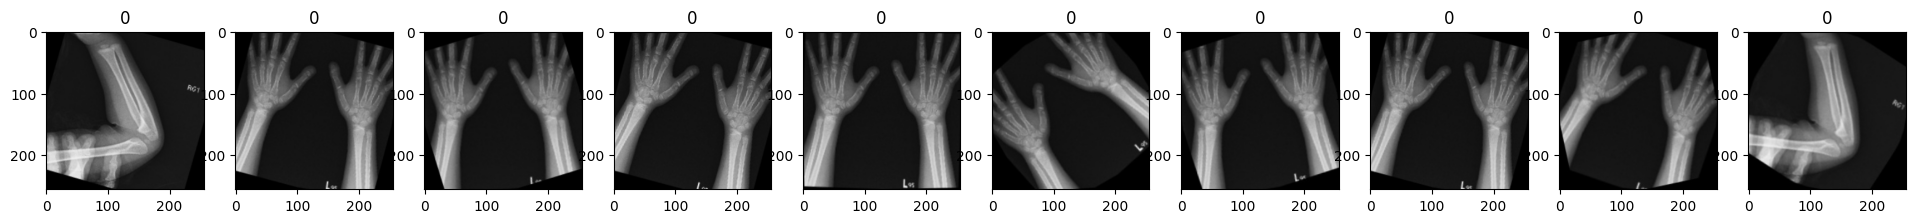

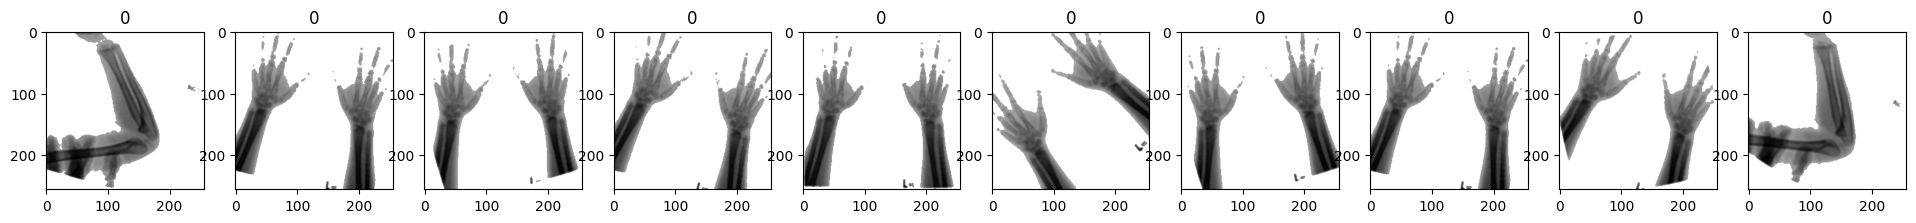

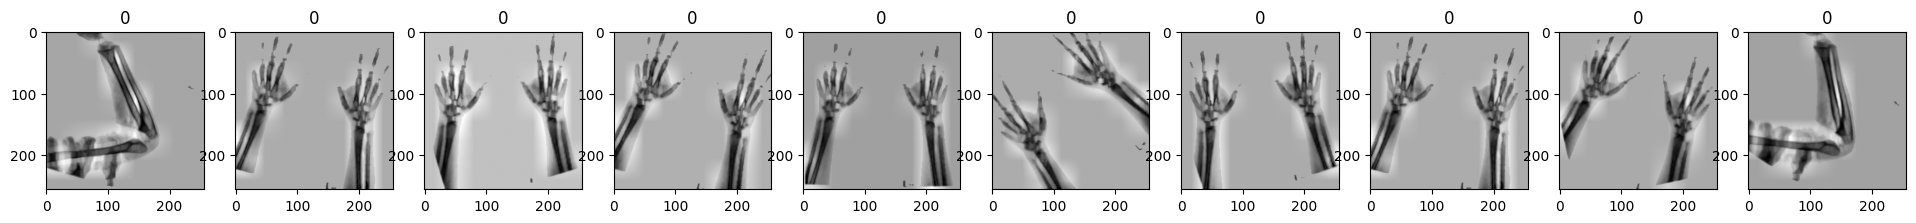

In [ ]:
for i in trainMask:
  # create clahe object
  clahe = cv2.createCLAHE(100, (8,8))
  # apply to segmented image
  clIMG = clahe.apply(i)

  # toning down the threshold using erosion
  kernel = np.ones((5, 1), np.uint8)
  # apply on mask
  finIMG = cv2.erode(clIMG, kernel, 1)

  # add to processed images list
  trainPro.append(finIMG)

size = 10

# NO FRACTURE:
fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display original image
    ax[i].imshow(trainIMG[i], cmap='binary')
    ax[i].set_title(trainLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display masks
    ax[i].imshow(trainMask[i], cmap='binary')
    ax[i].set_title(trainLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display processed image
    ax[i].imshow(trainPro[i], cmap='binary')
    ax[i].set_title(trainLABEL[i])

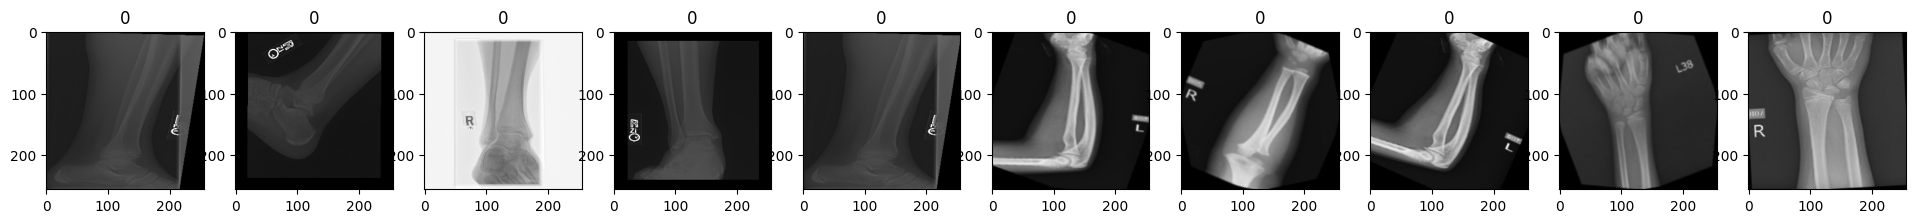

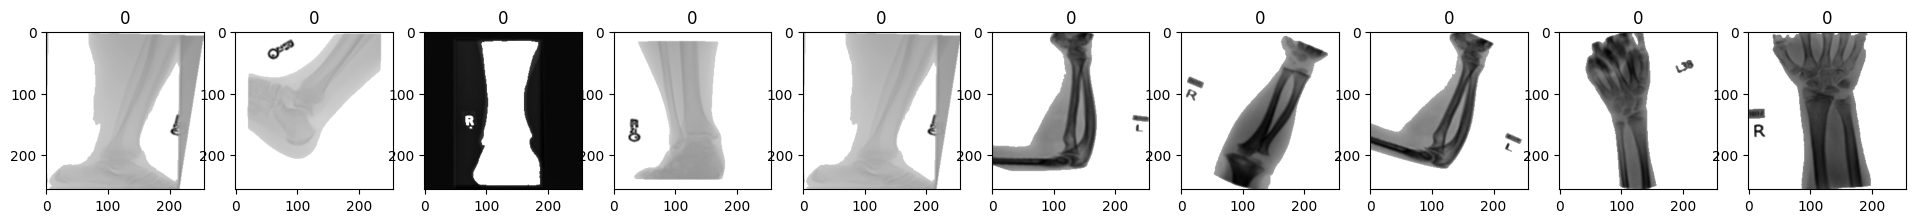

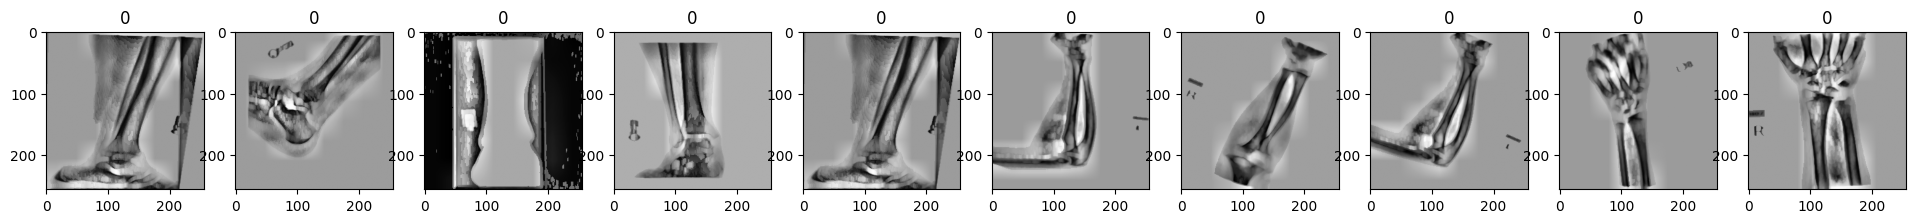

In [ ]:
# testing:

testMask = []
testPro = []

for i in testIMG:
  # convert to grayscale values
  imgGS = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  # denoise
  imgC = cv2.GaussianBlur(imgGS, (5,5), 0)
  # use OTSU thresholding
  ret, msk = cv2.threshold(imgC, 0, 255, cv2.THRESH_OTSU)
  mskdIMG = cv2.bitwise_and(imgC, imgC, mask=msk)
  testMask.append(mskdIMG)

for i in testMask:
  # create clahe object
  clahe = cv2.createCLAHE(100, (8,8))
  # apply to segmented image
  clIMG = clahe.apply(i)

  # toning down the threshold using erosion
  kernel = np.ones((5, 1), np.uint8)
  # apply on mask
  finIMG = cv2.erode(clIMG, kernel, 1)

  # add to processed images list
  testPro.append(finIMG)

size = 10

# NO FRACTURE:
fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display original image
    ax[i].imshow(testIMG[i], cmap='binary')
    ax[i].set_title(testLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display masks
    ax[i].imshow(testMask[i], cmap='binary')
    ax[i].set_title(testLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display processed image
    ax[i].imshow(testPro[i], cmap='binary')
    ax[i].set_title(testLABEL[i])

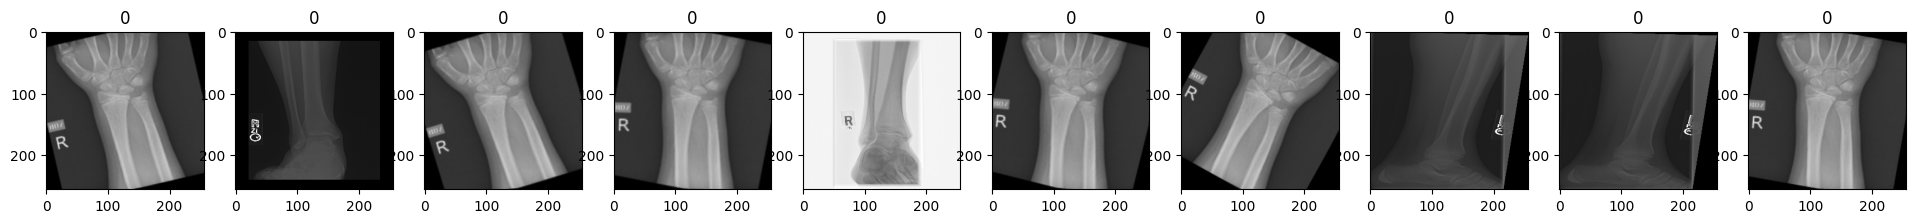

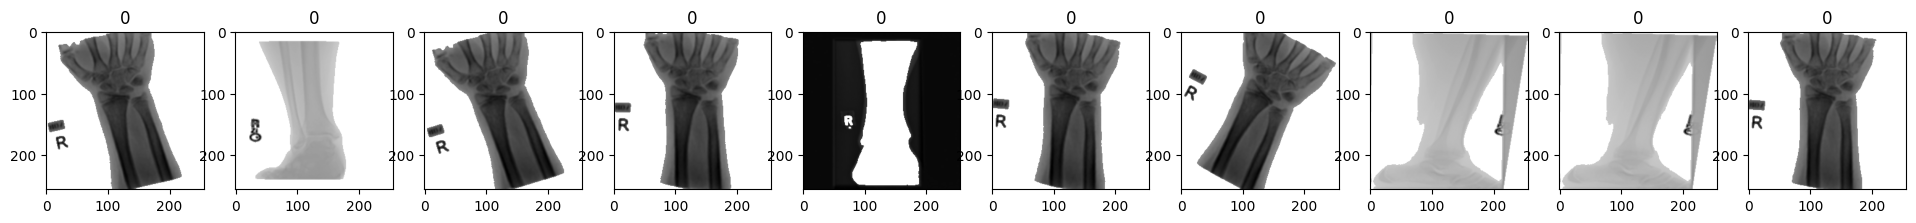

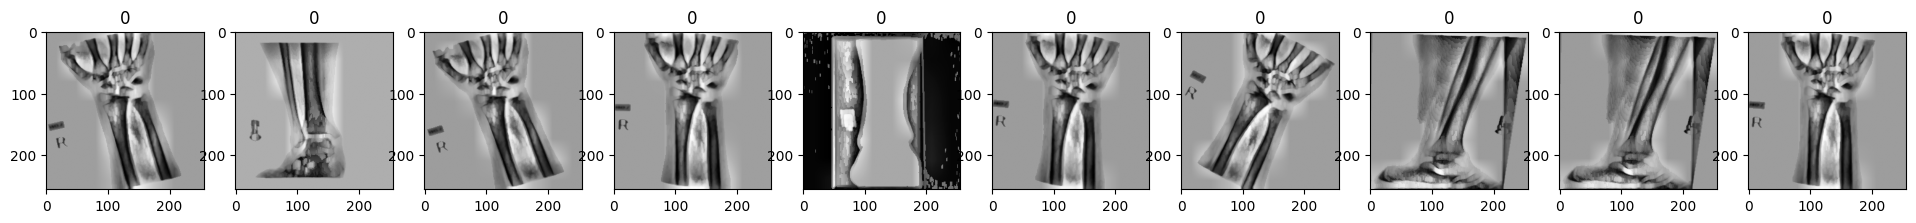

In [ ]:
# validation

valMask = []
valPro = []

for i in valIMG:
  # convert to grayscale values
  imgGS = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  # denoise
  imgC = cv2.GaussianBlur(imgGS, (5,5), 0)
  # use OTSU thresholding
  ret, msk = cv2.threshold(imgC, 0, 255, cv2.THRESH_OTSU)
  mskdIMG = cv2.bitwise_and(imgC, imgC, mask=msk)
  valMask.append(mskdIMG)

for i in valMask:
  # create clahe object
  clahe = cv2.createCLAHE(100, (8,8))
  # apply to segmented image
  clIMG = clahe.apply(i)

  # toning down the threshold using erosion
  kernel = np.ones((5, 1), np.uint8)
  # apply on mask
  finIMG = cv2.erode(clIMG, kernel, 1)

  # add to processed images list
  valPro.append(finIMG)

size = 10

# NO FRACTURE:
fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display original image
    ax[i].imshow(valIMG[i], cmap='binary')
    ax[i].set_title(valLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display masks
    ax[i].imshow(valMask[i], cmap='binary')
    ax[i].set_title(valLABEL[i])

fig, ax = plt.subplots(1, size, figsize=(24, 12))

for i in range(0, size):
    # display processed image
    ax[i].imshow(valPro[i], cmap='binary')
    ax[i].set_title(valLABEL[i])

In [ ]:
# CNN MODEL CREATION:
# note: layer order is always conv(relu) -> (repeat however many times) -> pool -> dropout -> (repeat this however many times) -> flatten -> dense(relu) -> dense(softmax, output = number of classes)

cnnModel = keras.Sequential()

# actual model layers:
cnnModel.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3))) # convolution
cnnModel.add(MaxPooling2D(pool_size=(2,2))) # pooling to downsize
cnnModel.add(Dropout(0.2)) # dropping some input pixels to make sure model is robust

cnnModel.add(Conv2D(64, (3, 3), activation='relu', padding='same',))
cnnModel.add(MaxPooling2D(pool_size=(2,2)))
cnnModel.add(Dropout(0.2))

cnnModel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnnModel.add(MaxPooling2D(pool_size=(2,2)))
cnnModel.add(Dropout(0.2))

cnnModel.add(Flatten())
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dropout(0.4))
cnnModel.add(Flatten())
cnnModel.add(Rescaling(1./255)) # to give less bias to "higher" values
cnnModel.add(Dense(2, activation='sigmoid')) # sigmoid is best for binary classification

cnnModel.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,853,334 (64.29 MB)

 Trainable params: 16,853,334 (64.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# conversion to numpy arrays
trainIMG = np.array(trainIMG)
trainLABEL = to_categorical(np.array(trainLABEL))
valIMG = np.array(valIMG)
valLABEL = to_categorical(np.array(valLABEL))
testIMG = np.array(testIMG)
testLABEL = to_categorical(np.array(testLABEL))

# group shapes
print(f"Training set: Training Images = {trainIMG.shape}, Training Labels = {trainLABEL.shape}")
print(f"Validation set: Validation Images = {valIMG.shape}, Validation Labels = {valLABEL.shape}")
print(f"Testing set: Training Images {testIMG.shape}, Training Labels = {testLABEL.shape}")

Training set: Training Images = (9243, 256, 256, 3), Training Labels = (9243, 2)
Validation set: Validation Images = (829, 256, 256, 3), Validation Labels = (829, 2)
Testing set: Training Images (506, 256, 256, 3), Training Labels = (506, 2)


Base Model Accuracy: 
98.6166000366211


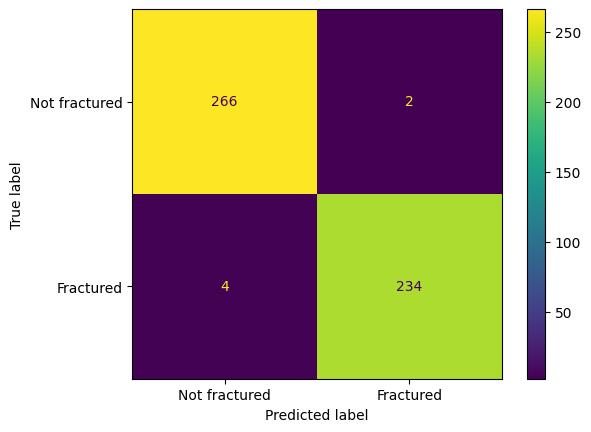

In [ ]:
# compiling and using the model

cnnModel.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(), # binary crossentropy since this is binary classification
              metrics=[BinaryAccuracy()]) # same rational as above ^

trainedCNN = cnnModel.fit(trainIMG, trainLABEL, epochs=5, batch_size=100, validation_data=(valIMG, valLABEL), shuffle=True) #enabling shuffle as this is binary classification


prediction = (cnnModel.predict(testIMG, verbose=0) > 0.5).astype("int") # converts it from probability values to 0s and 1s (label equivalents)
evaluation = cnnModel.evaluate(testIMG, testLABEL, verbose=0) # getting model accuracy
print("Base Model Accuracy: ")
print(evaluation[1]*100)

confMat = confusion_matrix(testLABEL.argmax(axis=1), prediction.argmax(axis=1)) # binary label types for conf matrix
dispConfMat = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["Not fractured", "Fractured"])

dispConfMat.plot()
plt.show()